# K modes

## Using K modes algorithm to find clusters 

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from scipy.stats import iqr
import time
%matplotlib inline

In [22]:
#import data

#Read in dataset with all rows included
df = pd.read_sas("Data/alldata3.sas7bdat")

scaler = StandardScaler()

df["age_sd"] = scaler.fit_transform(df[["AGE_YEARS"]])

#6931 DBD apps
dbd_apps = df[(df["eli_DBD"]==1)&(df["FAMILY_APPROACHED"]==2)]

#6060 DBD apps to match cohort in pape
dbd_apps = dbd_apps[(dbd_apps["eth_grp"]!=5)&(dbd_apps["FORMAL_APR_WHEN"]!=4)&(dbd_apps["donation_mentioned"]!=-1)
                    &(dbd_apps["FAMILY_WITNESS_BSDT"]!=9)&(dbd_apps["GENDER"]!=9)]

# Consented donors only
dbd_cons = dbd_apps[dbd_apps["FAMILY_CONSENT"]==2]

/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
/Users/roddy.jacques/opt/anaconda3/lib/python3.9/site-packages/pandas/io/sas/sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [140]:
# Columns used to create DBD model in paper
dbd_cols = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "age_sd", "FAMILY_CONSENT"]

dbd_cats = ["wish", "FORMAL_APR_WHEN", "donation_mentioned", "app_nature", "eth_grp", "religion_grp", "GENDER", "FAMILY_WITNESS_BSDT", "DTC_PRESENT_BSD_CONV", 
            "acorn_new", "FAMILY_CONSENT"]

dbd_apps[dbd_cats].astype(int)

for cat in dbd_cats:
    dbd_apps[cat] = dbd_apps[cat].astype(int)

dbd_model_data = dbd_apps.loc[:,dbd_cols]
    
dbd_train = dbd_model_data.to_numpy()

In [141]:
max_clusters = 7
n_clusters = range(2,max_clusters+1)
costs = []

for k in range(2,max_clusters+1):
    KP = KPrototypes(n_clusters=k)
    KP.fit_predict(dbd_train,categorical=list(range(0,10))+[11])
    costs.append(KP.cost_)

Text(0, 0.5, 'Cost')

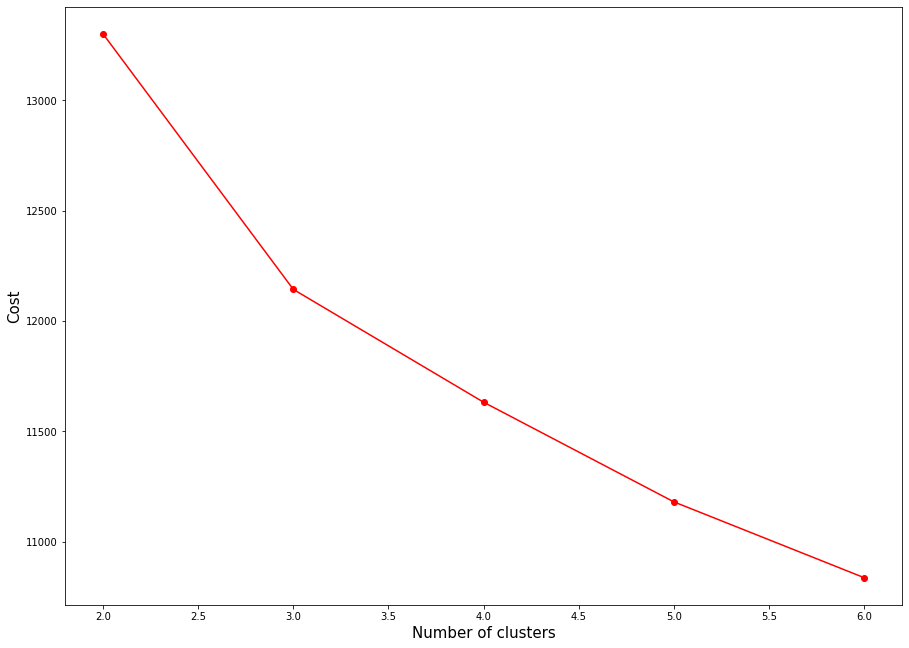

In [142]:
fig, ax = plt.subplots(1,1,figsize=[15,11],facecolor="white")
ax.plot(n_clusters,costs,"ro-")
plt.xlabel("Number of clusters", fontsize=15)
plt.ylabel("Cost", fontsize=15)

In [165]:
KP = KPrototypes(n_clusters=4,random_state=66)
KP.fit_predict(dbd_train,categorical=list(range(0,10))+[11])
dbd_model_data["cluster_k4"] = KP.labels_

In [166]:
dbd_model_data["age"]= scaler.inverse_transform(dbd_model_data["age_sd"])

dbd_model_data.head()

,wish,FORMAL_APR_WHEN,donation_mentioned,app_nature,eth_grp,religion_grp,GENDER,FAMILY_WITNESS_BSDT,DTC_PRESENT_BSD_CONV,acorn_new,age_sd,FAMILY_CONSENT,cluster_k3,age,cluster_k4
10,3,3,1,2,1,4,1,1,2,4,0.635769,2,0,71.0,0
11,1,3,1,2,1,4,2,1,2,4,0.744975,2,0,73.0,0
16,1,1,1,2,1,1,1,1,2,5,0.526564,2,0,69.0,0
26,4,1,4,2,1,9,2,1,2,4,0.035141,2,2,60.0,2
30,4,3,4,2,1,9,1,1,2,4,0.417359,1,0,67.0,0


In [167]:
k4_summary = dbd_model_data.iloc[:,[-2,-1]].groupby("cluster_k4").agg(["median",iqr]).T
k4_summary

cluster_k4     0     1     2     3
age median  68.0  26.0  52.0  49.0
    iqr     11.0  13.0  11.0  10.0

In [213]:
def cat_summary(k,col):
    
    summary = dbd_model_data.value_counts(["cluster_k"+str(k),col],sort=False).reset_index(name="count")
    summary["Pct"] = round(100*summary.iloc[:,-1] / summary.groupby("cluster_k"+str(k))["count"].transform('sum'),1)
    
    baseline = dbd_model_data.value_counts(col,sort=False).reset_index(name="count")
    baseline["Baseline Pct"] = round(100*baseline["count"] / baseline["count"].sum(),1)
    
    summary2 = pd.merge(summary,baseline[[col,"Baseline Pct"]],on=col,how="left")
    
    plot1 = sns.catplot(x=col,y="Pct",col="cluster_k"+str(k),data=summary2,kind='bar',color="#005EB8")
    
    print(summary2)
    
    return plot1

    cluster_k4  wish  count   Pct  Baseline Pct
0            0     1    944  55.6          56.5
1            0     2     91   5.4           4.8
2            0     3    273  16.1          15.3
3            0     4    328  19.3          18.1
4            0     5     62   3.7           5.3
5            1     1    780  57.5          56.5
6            1     2     68   5.0           4.8
7            1     3    167  12.3          15.3
8            1     4    237  17.5          18.1
9            1     5    105   7.7           5.3
10           2     1    894  48.0          56.5
11           2     2    109   5.9           4.8
12           2     3    353  19.0          15.3
13           2     4    412  22.1          18.1
14           2     5     93   5.0           5.3
15           3     1    807  70.5          56.5
16           3     2     22   1.9           4.8
17           3     3    133  11.6          15.3
18           3     4    121  10.6          18.1
19           3     5     61   5.3       

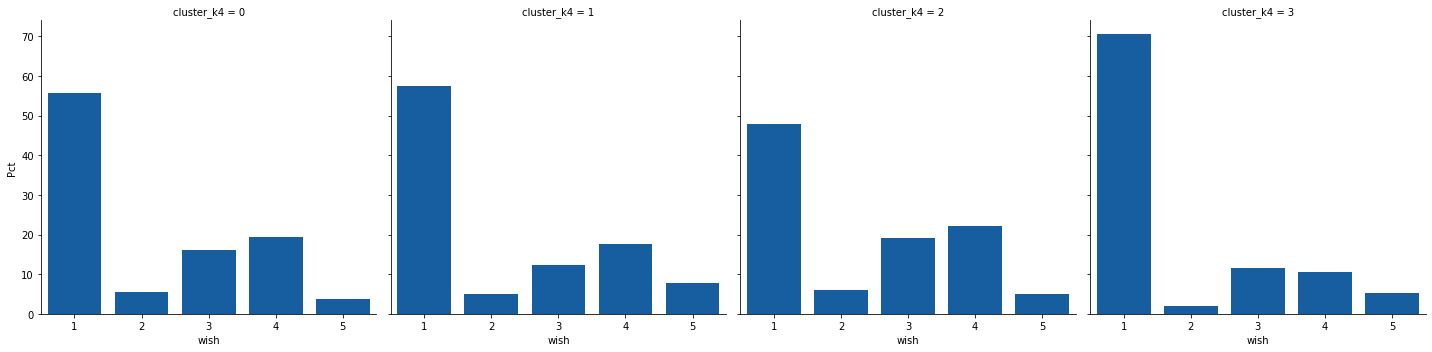

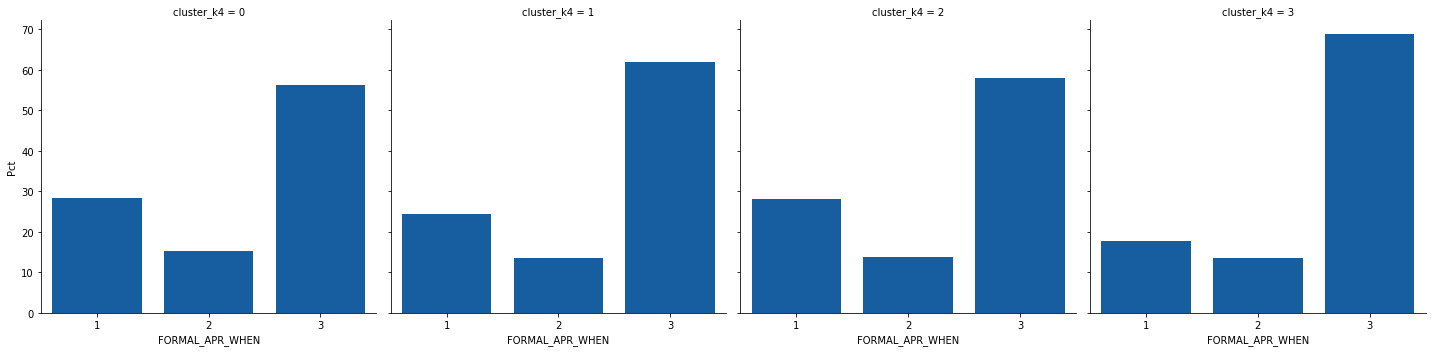

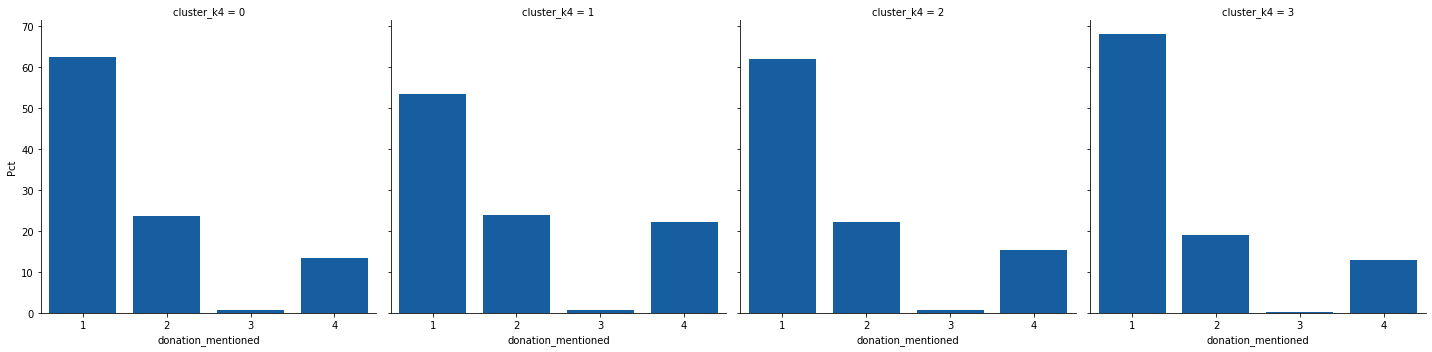

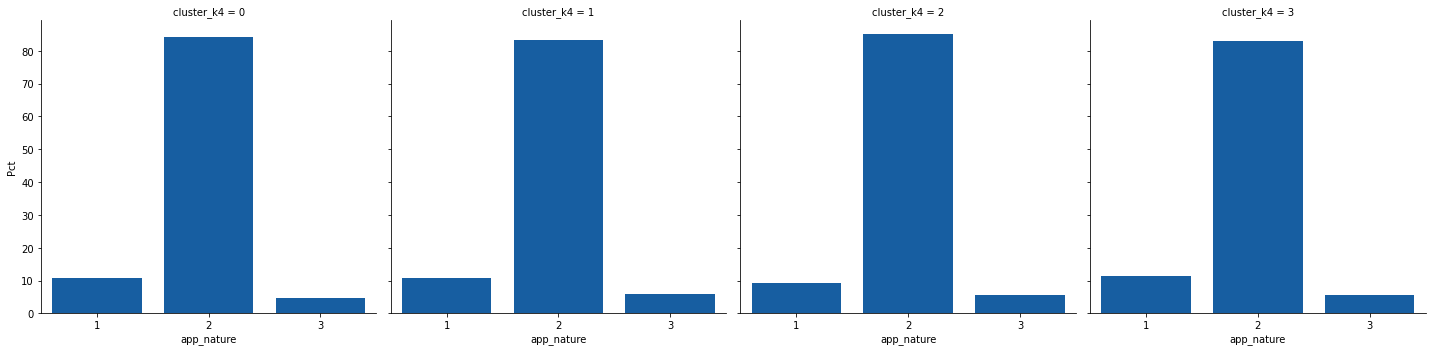

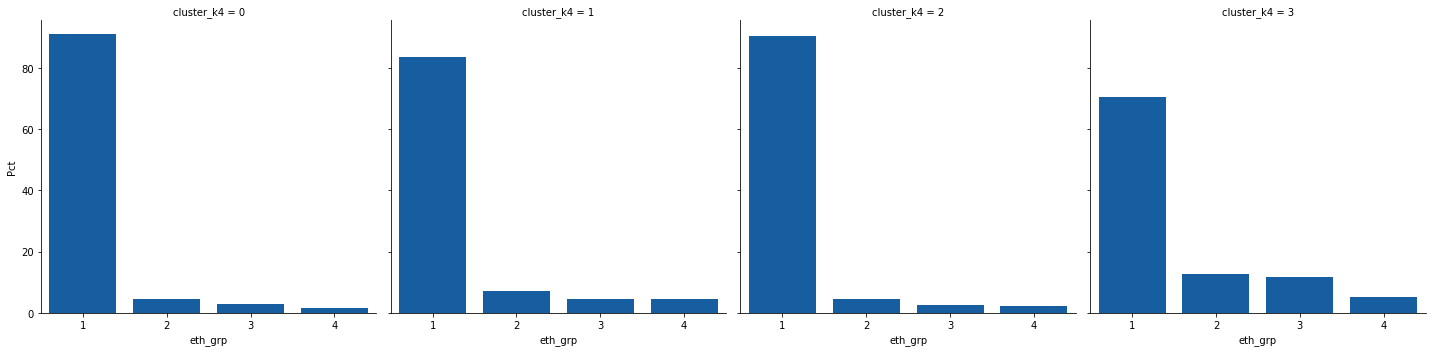

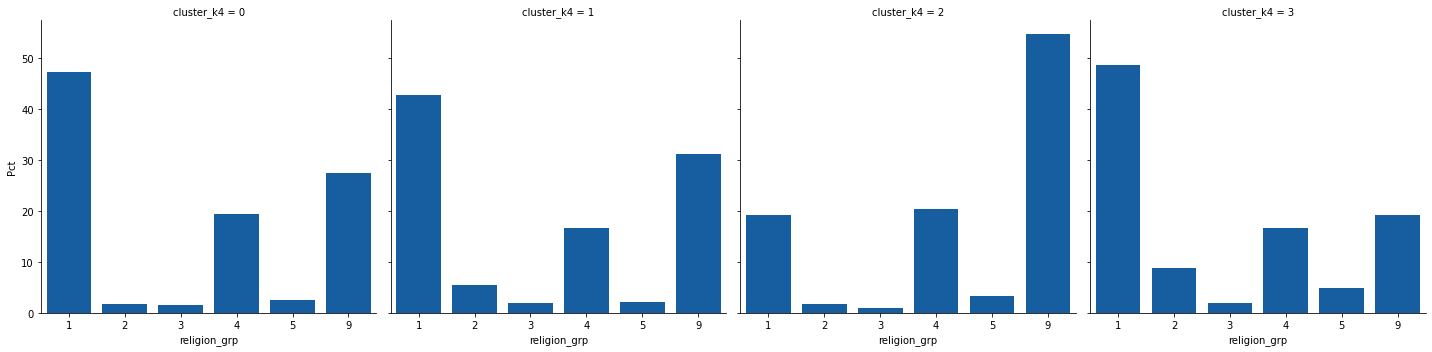

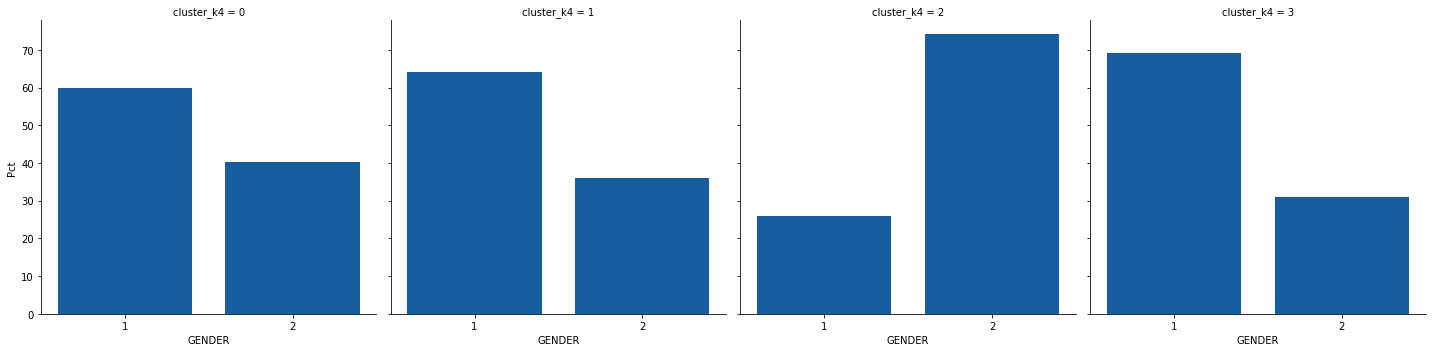

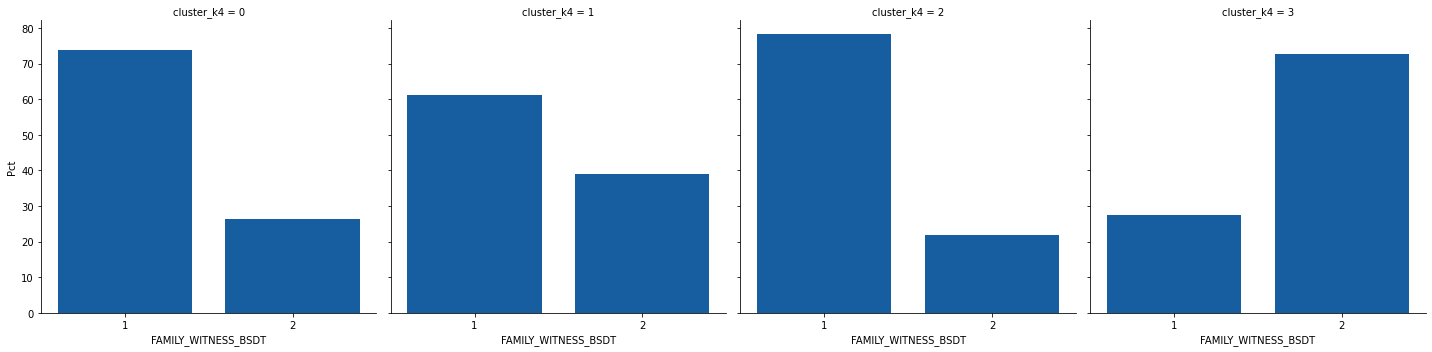

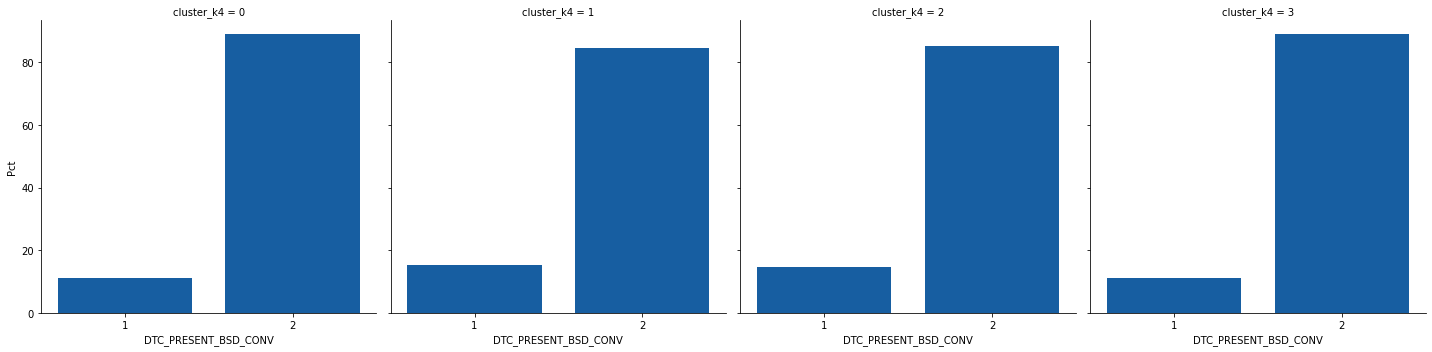

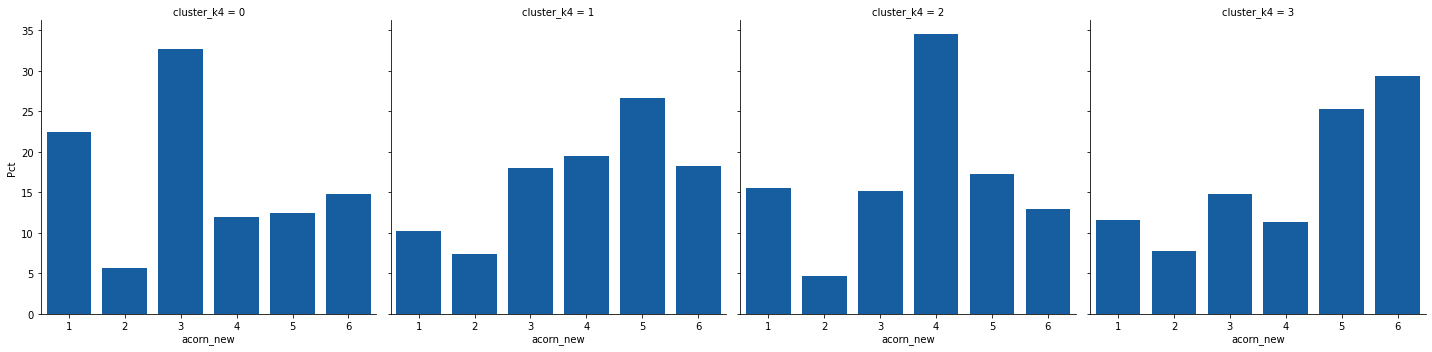

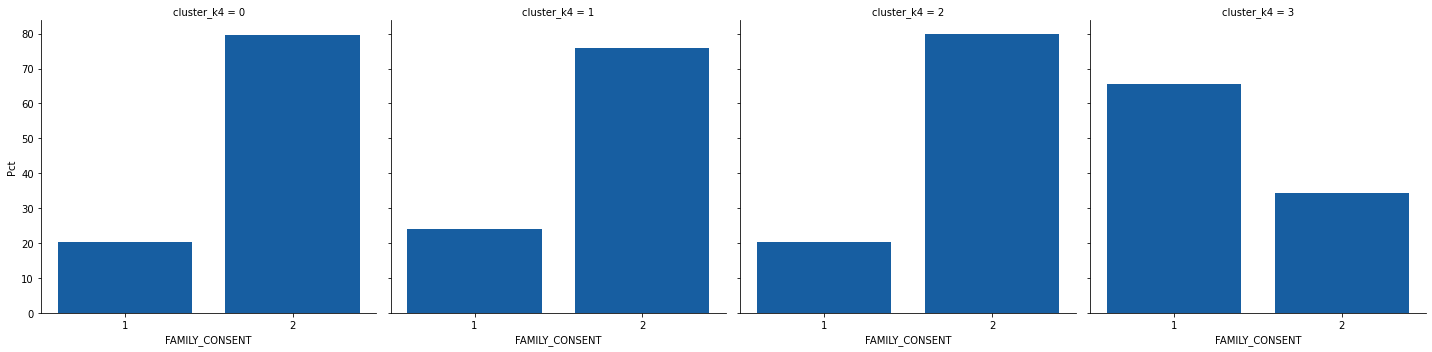

In [214]:
for cat in dbd_cats:
    cat_summary(4,cat)